Data from the paper:  
[D'Souza, M. L., & Hebert, P. D. (2018). Stable baselines of temporal turnover underlie high beta diversity in tropical arthropod communities. Molecular ecology, 27(10), 2447-2460.](http://biodiversitygenomics.net/site/wp-content/uploads/2018/06/2018-DSouza-Stable-baselines-of-temporal-turnover.pdf)

Data can be obtained from:  
1. Go to BOLD4: http://www.boldsystems.org/index.php
2. Select 'Databases'
3. Select 'Public Data Portal'
4. Type in 'DS-MECNP'

In [1]:
!ls

bold_data.txt  cusuco_arthropods_preprocessing.ipynb  fasta.fas  fastas


## Read in the metadata
We don't like spaces in the 'exactsite' field, so we'll replace with underscore.

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os
import shutil
import easyCGD


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named easyCGD

In [195]:
meta = pd.read_csv("bold_data.txt", sep="\t", index_col=0)
meta["exactsite"] = meta["exactsite"].str.replace(" ", "_")
meta

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,40,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sampleid,recordID,catalognum,fieldnum,institution_storing,collection_code,bin_uri,phylum_taxID,phylum_name,class_taxID,...,exactsite,image_ids,image_urls,media_descriptors,captions,copyright_holders,copyright_years,copyright_licenses,copyright_institutions,photographers
processid,,,,,,,,,,,,,,,,,,,,,
GMHDA020-13,BIOUG04577-A08,3061889,BIOUG04577-A08,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACD3595,20,Arthropoda,82.0,...,Base_Camp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMHDA061-13,BIOUG04579-B11,3061930,BIOUG04579-B11,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACD2774,20,Arthropoda,82.0,...,Base_Camp,1962119,http://www.boldsystems.org/pics/GMHDA/BIOUG045...,Lateral,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza
GMHDA097-13,BIOUG04579-E11,3061966,BIOUG04579-E11,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACD2844,20,Arthropoda,82.0,...,Base_Camp,1962145,http://www.boldsystems.org/pics/GMHDA/BIOUG045...,Dorsal,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza
GMHDA230-13,BIOUG04581-A02,3062099,BIOUG04581-A02,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACF7207,20,Arthropoda,82.0,...,Base_Camp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMHDA338-13,BIOUG04494-E06,3157537,BIOUG04494-E06,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACF8348,20,Arthropoda,82.0,...,Base_Camp,2058350,http://www.boldsystems.org/pics/GMHDA/IMG_1022...,Lateral,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza
GMHDA384-13,BIOUG04933-G11,3157583,BIOUG04933-G11,GMP#00525,Centre for Biodiversity Genomics,NaN,BOLD:ACF6516,20,Arthropoda,82.0,...,Base_Camp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMHDB121-13,BIOUG04568-G08,3157595,BIOUG04568-G08,GMP#00526,Centre for Biodiversity Genomics,NaN,BOLD:ACF9349,20,Arthropoda,82.0,...,Base_Camp,2058379,http://www.boldsystems.org/pics/GMHDB/IMG_1067...,Dorsal,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza
GMHDC015-13,BIOUG04577-C07,3080683,BIOUG04577-C07,GMP#00521,Centre for Biodiversity Genomics,NaN,BOLD:ACD3764,20,Arthropoda,82.0,...,Base_Camp,1960971,http://www.boldsystems.org/pics/GMHDC/BIOUG045...,Dorsal,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza
GMHDC115-13,BIOUG04608-C07,3080783,BIOUG04608-C07,GMP#00521,Centre for Biodiversity Genomics,NaN,BOLD:ACD3224,20,Arthropoda,82.0,...,Base_Camp,1961866,http://www.boldsystems.org/pics/GMHDC/BIOUG046...,Lateral,NaN,CBG Photography Group,2013,CreativeCommons - Attribution Non-Commercial S...,Centre for Biodiversity Genomics,Michelle D’Souza


## Get the site list and make the fasta outdirs

In [206]:
sites = list(set(meta["exactsite"]))
sites

['Base_Camp', 'Cantiles', 'El_Cortecito', 'Guanales', 'El_Danto']

## Use the bold ID as the organizing unit
Some samples don't have the 'bin_uri' set, about 10%. Let just ignore these for now

In [196]:
print("Number of samples w/o BIN ID: {}".format(np.sum(meta["bin_uri"].isnull())))
## Get just the good ones
print(len(meta))
no_bin = meta[meta["bin_uri"].isnull()]
meta = meta[~meta["bin_uri"].isnull()]
print(len(meta), len(no_bin))

Number of samples w/o BIN ID: 8215
59767
51552 8215


## Create a dict mapping "proccessid" (sample name) to "bin_uri" (OTU)

In [124]:
pid_to_bin_dict = {}
#for idx, row in has_bin[["processid", "bin_uri"]].iterrows():
for idx, uri in meta[["bin_uri"]].iterrows():
    pid_to_bin_dict[idx] = uri
print(list(pid_to_bin_dict.values())[:20])
#has_bin[["processid", "bin_uri"]]
#has_bin[["bin_uri"]]

[bin_uri    BOLD:ACD3595
Name: GMHDA020-13, dtype: object, bin_uri    BOLD:ACD2774
Name: GMHDA061-13, dtype: object, bin_uri    BOLD:ACD2844
Name: GMHDA097-13, dtype: object, bin_uri    BOLD:ACF7207
Name: GMHDA230-13, dtype: object, bin_uri    BOLD:ACF8348
Name: GMHDA338-13, dtype: object, bin_uri    BOLD:ACF6516
Name: GMHDA384-13, dtype: object, bin_uri    BOLD:ACF9349
Name: GMHDB121-13, dtype: object, bin_uri    BOLD:ACD3764
Name: GMHDC015-13, dtype: object, bin_uri    BOLD:ACD3224
Name: GMHDC115-13, dtype: object, bin_uri    BOLD:ACF9238
Name: GMHDC161-13, dtype: object, bin_uri    BOLD:ACD3260
Name: GMHDD069-13, dtype: object, bin_uri    BOLD:ACE1746
Name: GMHDD140-13, dtype: object, bin_uri    BOLD:ACF8543
Name: GMHDE035-13, dtype: object, bin_uri    BOLD:ACF6992
Name: GMHDE155-13, dtype: object, bin_uri    BOLD:ACD3258
Name: GMHDE230-13, dtype: object, bin_uri    BOLD:ACF7442
Name: GMHDF011-13, dtype: object, bin_uri    BOLD:ACG1235
Name: GMHDF072-13, dtype: object, bin_uri    BO

## Parse the giant fasta file into fastas per OTU per sampling site

In [208]:
def parse_fasta_file(fasta_file, output_path="fastas", quiet=True):

    ## Just automaticallyl clean up any fastadir that already exists and recreate the directory structure
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    for site in sites:
        if not os.path.exists(os.path.join(output_path, site)):
            os.mkdir(os.path.join(output_path, site))

    ## Parse the fasta file into a dictionary of sample IDs and sequences
    miss_dict = {}
    with open(fasta_file, 'r') as fasta:
        for line1,line2 in itertools.zip_longest(*[fasta]*2):
            key = line1.strip().strip(">").split("|")[0]
            seq = line2.strip()

            try:
                otu = meta.loc[key]["bin_uri"]
                if otu == "nan":
                    raise Exception("Sample w/o bin_uri")
                site = meta.loc[key]["exactsite"]
                with open("{}/{}/{}.fasta".format(output_path, site, otu), 'a+') as outfile:
                    outfile.write("{}\n{}\n".format(">"+key, seq))
#                with open("{}/{}/Combined/{}.fasta".format(output_path, site, otu), 'a+') as outfile:
#                    outfile.write("{}\n{}\n".format(">"+key, seq))

            except Exception as inst:
                miss_dict[key] = seq
                if not quiet:
                    print("{} failed - {}".format(key, inst))
                pass
    return miss_dict
missed = parse_fasta_file("fasta.fas", "fastas", quiet=True)

In [212]:
dfs = {}
for site in sites:
    dfs[site] = easyCGD.get_pis_from_fastas(fasta_dir=os.path.join(fastadir, site),
                                            outfile=os.path.join(fastadir, "{}.pis".format(site)),
                                            colname=site)

In [213]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfs["Base_Camp"])

              Base_Camp
BOLD:ACZ5183   0.000000
BOLD:ABU5521   0.592767
BOLD:ACZ9012   0.017322
BOLD:ACJ9183   0.000000
BOLD:ACZ5725   0.000000
BOLD:ACS4094   0.008114
BOLD:ACZ3955   0.000000
BOLD:ACJ6597   0.007901
BOLD:ACJ8890   0.013850
BOLD:AAJ3824   0.000000
BOLD:ACE0720   0.007800
BOLD:ACZ6372   0.000000
BOLD:ACE1631   0.018444
BOLD:ACS9096   0.000000
BOLD:ACS4839   0.000000
BOLD:ACT2657   0.000000
BOLD:ACE0537   0.016954
BOLD:ACZ6211   0.000000
BOLD:ACT9073   0.024957
BOLD:ADA8683   0.000000
BOLD:ACJ5337   0.094217
BOLD:ACY8525   0.013020
BOLD:ADA6486   0.000000
BOLD:ACE2725   0.008378
BOLD:ADA0183   0.029345
BOLD:ACZ5337   0.000000
BOLD:ADA4602   0.016987
BOLD:ADA3445   0.000000
BOLD:ACD9944   0.000000
BOLD:ACJ8178   0.025059
BOLD:ACD2776   0.024340
BOLD:ACS8298   0.000000
BOLD:ACF8137   0.000000
BOLD:ACE1741   0.000000
BOLD:ACZ5724   0.000000
BOLD:ACD3312   0.000000
BOLD:ACJ4365   0.000000
BOLD:ACS8350   0.000000
BOLD:ACJ7290   0.021054
BOLD:ACF8405   0.000000
BOLD:ABA9425   0

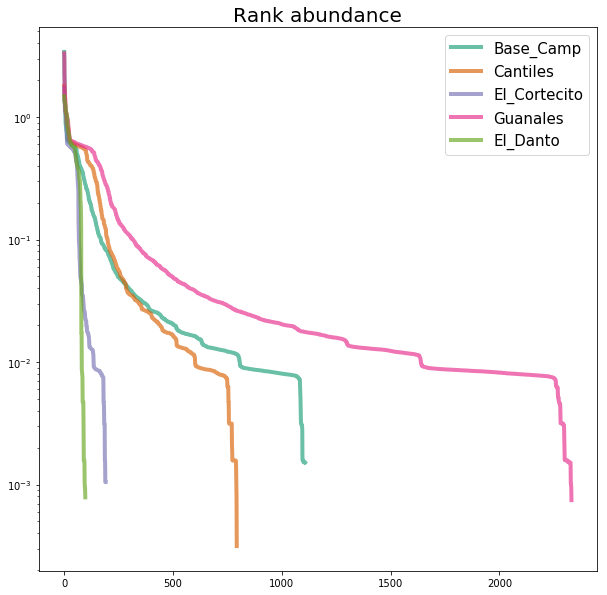

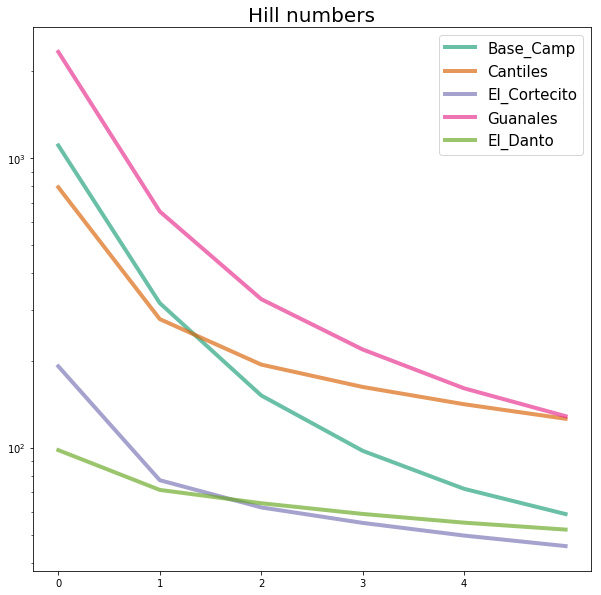

In [214]:
cmap = {'Base_Camp':"#1b9e77",
        'Cantiles':"#d95f02",
        'El_Cortecito':"#7570b3",
        'Guanales':"#e7298a",
        'El_Danto':"#66a61e"}
fig, ax = plt.subplots(figsize=(10,10))
for site, df in dfs.items():
    easyCGD.plot_RACs(df, ax=ax, color=cmap[site])
fig, ax = plt.subplots(figsize=(10,10))
for site, df in dfs.items():
    easyCGD.plot_hill_numbers(df, ax=ax, color=cmap[site])

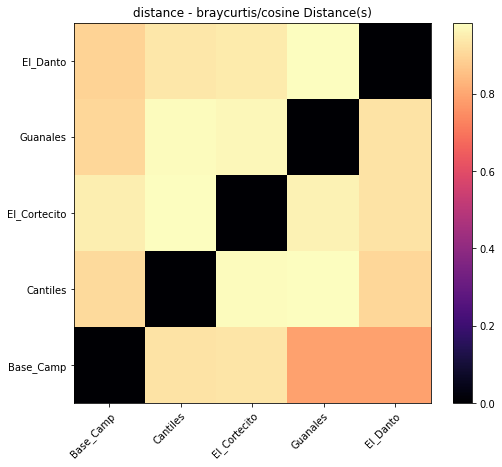

In [216]:
df = pd.concat(dfs.values(), ignore_index=False, axis=1, sort=True)
dat = df.T.fillna(value=0)
mx = easyCGD.plot_distances(dat, labels=df.columns, metric=["braycurtis", "cosine"])

In [225]:
print(meta.columns)
meta.iloc[0].values
set(meta["collection_note"])

Index(['sampleid', 'recordID', 'catalognum', 'fieldnum', 'institution_storing',
       'collection_code', 'bin_uri', 'phylum_taxID', 'phylum_name',
       'class_taxID', 'class_name', 'order_taxID', 'order_name',
       'family_taxID', 'family_name', 'subfamily_taxID', 'subfamily_name',
       'genus_taxID', 'genus_name', 'species_taxID', 'species_name',
       'subspecies_taxID', 'subspecies_name', 'identification_provided_by',
       'identification_method', 'identification_reference', 'tax_note',
       'voucher_status', 'tissue_type', 'collection_event_id', 'collectors',
       'collectiondate_start', 'collectiondate_end', 'collectiontime',
       'collection_note', 'site_code', 'sampling_protocol', 'lifestage', 'sex',
       'reproduction', 'habitat', 'associated_specimens', 'associated_taxa',
       'extrainfo', 'notes', 'lat', 'lon', 'coord_source', 'coord_accuracy',
       'elev', 'depth', 'elev_accuracy', 'depth_accuracy', 'country',
       'province_state', 'region', 'sector'

{'BC01',
 'BC02',
 'BC03',
 'BC04',
 'BC05',
 'BC06',
 'BC07',
 'BC08',
 'BC09',
 'BC10',
 'BC11',
 'BC12',
 'BC13',
 'BC14',
 'BC15',
 'BC16',
 'BC17',
 'BC18',
 'BC19',
 'BC20',
 'BC21',
 'BC22',
 'BC23',
 'BC24',
 'BC25',
 'BC26',
 'BC27',
 'BC28',
 'BC29',
 'BC30',
 'GU01',
 'GU02',
 'GU03',
 'GU04',
 'GU05',
 'GU06',
 'GU07',
 'GU08',
 'GU09',
 'GU10',
 'GU11',
 'GU12',
 'GU13',
 'GU14',
 'GU15',
 'GU16',
 'GU17',
 'GU18',
 'GU19',
 'GU20',
 'GU21',
 'GU22',
 'GU23',
 'GU24',
 'GU25',
 'GU26',
 'GU27',
 'GU28',
 'GU29',
 'Honduras 2014 Cantiles Trap 1',
 'Honduras 2014 Cantiles Trap 2',
 'Honduras 2014 Cantiles Trap 3',
 'Honduras 2014 Cantiles Trap 4',
 'Honduras 2014 Cantiles Trap 5',
 'Honduras 2014 Cantiles Trap 6',
 'Honduras 2014 Cantiles Trap 7',
 'Honduras 2014 Cantiles Trap 8',
 'Honduras 2014 El Cortecito Trap 1',
 'Honduras 2014 El Cortecito Trap 2',
 'Honduras 2014 El Cortecito Trap 3',
 'Honduras 2014 El Cortecito Trap 4',
 'Honduras 2014 El Cortecito xtra',
 'Hondura

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import MESS
pis = open("fastas/El_Danto.pis").readlines()[1:]
pis = np.array([float(x.split(",")[1].strip()) for x in pis])
#print(pis)
#plt.hist(pis)
#MESS.SGD(pis=pis)
print(pis[pis > 0.5])


[1.28395439 0.82300839 0.63522013 1.31789864 0.6336478  0.5927673
 0.51572327 1.07326676 0.65566038 0.50943396 0.57389937 1.00366876
 0.71881551 0.72684686 1.06729264 0.55188679 1.35602182 1.01519916
 0.60062893 0.60849057 0.76687631 1.47984938 0.60062893 1.04769392
 1.29612159 0.58490566 1.08562768 0.67473795 0.56964006 0.75172956
 0.66787212 0.57704403 0.56289308 0.5754717  1.1567086  0.5990566
 0.56761006 0.57217213 0.76226415 0.60062893 0.71598532 0.63050314
 0.56918239 0.57075472 0.84512579 1.21121593 1.1278826  0.5927673
 0.56918239 1.39377059 0.51040277 0.57805825 0.91719078]
